In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
import torch
from torch import nn

In [4]:
class LTSF_Linear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_Linear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x

In [5]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 
    
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [6]:
class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

In [7]:
def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    print(col)
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        # test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]
    # return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]

In [8]:
def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

In [9]:
from torch.utils.data import Dataset, DataLoader

In [10]:
class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [12]:
train_df = pd.read_csv('train.csv')[['ID','timestamp','supply(kg)', 'price(원/kg)']]
test_df = pd.read_csv('test.csv')[['ID','timestamp']]

In [13]:
train_df = train_df.drop(columns=['ID'])
test_df = test_df.drop(columns=['ID'])

In [14]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

In [15]:
### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size = 28
batch_size = 32
targets = 'price(원/kg)'
date = 'timestamp'

In [16]:
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'timestamp', targets)

['supply(kg)', 'price(원/kg)']


In [17]:
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
# test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)

In [18]:
train_df_fe.shape

(59397, 3)

In [19]:
train_x.shape

(59298, 72, 1)

In [20]:
train_y.shape

(59298, 28)

In [21]:
train_len = 40000
test_len = 10000

train_ds = Data(train_x[:train_len], train_y[:train_len])
valid_ds = Data(train_x[train_len:train_len+test_len],
                train_y[train_len:train_len+test_len])
test_ds = Data(train_x[train_len+test_len:], train_y[train_len+test_len:])
# test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)
valid_dl = DataLoader(valid_ds, batch_size = train_x[train_len:train_len+test_len].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = train_x[train_len+test_len:].shape[0], shuffle=False)
# test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

In [22]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [23]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )

criterion = torch.nn.MSELoss()
# criterion = RMSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

In [24]:
for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:36,  1.33it/s]

valid_loss=0.209, test_los0.196, Model Save
epoch = 1, train_loss : 0.406, valid_loss : 0.209, test_loss : 0.196


  4%|▍         | 2/50 [00:01<00:31,  1.54it/s]

epoch = 2, train_loss : 0.392, valid_loss : 0.214, test_loss : 0.201


  6%|▌         | 3/50 [00:01<00:28,  1.65it/s]

epoch = 3, train_loss : 0.392, valid_loss : 0.211, test_loss : 0.197


  8%|▊         | 4/50 [00:02<00:27,  1.65it/s]

valid_loss=0.208, test_los0.194, Model Save
epoch = 4, train_loss : 0.392, valid_loss : 0.208, test_loss : 0.194


 10%|█         | 5/50 [00:03<00:27,  1.65it/s]

epoch = 5, train_loss : 0.392, valid_loss : 0.211, test_loss : 0.198


 12%|█▏        | 6/50 [00:03<00:27,  1.60it/s]

epoch = 6, train_loss : 0.393, valid_loss : 0.214, test_loss : 0.200


 14%|█▍        | 7/50 [00:04<00:26,  1.61it/s]

epoch = 7, train_loss : 0.392, valid_loss : 0.210, test_loss : 0.197


 16%|█▌        | 8/50 [00:05<00:26,  1.59it/s]

valid_loss=0.207, test_los0.194, Model Save
epoch = 8, train_loss : 0.392, valid_loss : 0.207, test_loss : 0.194


 18%|█▊        | 9/50 [00:05<00:25,  1.61it/s]

epoch = 9, train_loss : 0.392, valid_loss : 0.208, test_loss : 0.194


 20%|██        | 10/50 [00:06<00:25,  1.57it/s]

epoch = 10, train_loss : 0.392, valid_loss : 0.213, test_loss : 0.199


 22%|██▏       | 11/50 [00:06<00:24,  1.60it/s]

epoch = 11, train_loss : 0.393, valid_loss : 0.209, test_loss : 0.196


 24%|██▍       | 12/50 [00:07<00:24,  1.55it/s]

epoch = 12, train_loss : 0.392, valid_loss : 0.209, test_loss : 0.196


 26%|██▌       | 13/50 [00:08<00:23,  1.55it/s]

epoch = 13, train_loss : 0.392, valid_loss : 0.210, test_loss : 0.196


 28%|██▊       | 14/50 [00:08<00:23,  1.52it/s]

epoch = 14, train_loss : 0.392, valid_loss : 0.208, test_loss : 0.195


 30%|███       | 15/50 [00:09<00:22,  1.53it/s]

epoch = 15, train_loss : 0.393, valid_loss : 0.212, test_loss : 0.198


 32%|███▏      | 16/50 [00:10<00:21,  1.55it/s]

epoch = 16, train_loss : 0.393, valid_loss : 0.210, test_loss : 0.196


 34%|███▍      | 17/50 [00:10<00:20,  1.58it/s]

valid_loss=0.206, test_los0.193, Model Save
epoch = 17, train_loss : 0.392, valid_loss : 0.206, test_loss : 0.193


 36%|███▌      | 18/50 [00:11<00:20,  1.57it/s]

epoch = 18, train_loss : 0.392, valid_loss : 0.208, test_loss : 0.195


 38%|███▊      | 19/50 [00:12<00:19,  1.60it/s]

epoch = 19, train_loss : 0.392, valid_loss : 0.208, test_loss : 0.195


 40%|████      | 20/50 [00:12<00:18,  1.60it/s]

epoch = 20, train_loss : 0.392, valid_loss : 0.213, test_loss : 0.199


 42%|████▏     | 21/50 [00:13<00:17,  1.63it/s]

epoch = 21, train_loss : 0.393, valid_loss : 0.211, test_loss : 0.197


 44%|████▍     | 22/50 [00:13<00:17,  1.61it/s]

epoch = 22, train_loss : 0.392, valid_loss : 0.213, test_loss : 0.199


 46%|████▌     | 23/50 [00:14<00:16,  1.64it/s]

valid_loss=0.205, test_los0.192, Model Save
epoch = 23, train_loss : 0.392, valid_loss : 0.205, test_loss : 0.192


 48%|████▊     | 24/50 [00:15<00:15,  1.64it/s]

epoch = 24, train_loss : 0.393, valid_loss : 0.208, test_loss : 0.194


 50%|█████     | 25/50 [00:15<00:15,  1.67it/s]

epoch = 25, train_loss : 0.392, valid_loss : 0.208, test_loss : 0.194


 52%|█████▏    | 26/50 [00:16<00:14,  1.63it/s]

epoch = 26, train_loss : 0.392, valid_loss : 0.211, test_loss : 0.198


 54%|█████▍    | 27/50 [00:16<00:13,  1.65it/s]

epoch = 27, train_loss : 0.392, valid_loss : 0.206, test_loss : 0.193


 56%|█████▌    | 28/50 [00:17<00:13,  1.69it/s]

epoch = 28, train_loss : 0.392, valid_loss : 0.206, test_loss : 0.192


 58%|█████▊    | 29/50 [00:18<00:12,  1.64it/s]

epoch = 29, train_loss : 0.392, valid_loss : 0.214, test_loss : 0.200


 60%|██████    | 30/50 [00:18<00:12,  1.65it/s]

epoch = 30, train_loss : 0.392, valid_loss : 0.211, test_loss : 0.197


 62%|██████▏   | 31/50 [00:19<00:11,  1.63it/s]

epoch = 31, train_loss : 0.393, valid_loss : 0.212, test_loss : 0.198


 64%|██████▍   | 32/50 [00:19<00:10,  1.64it/s]

epoch = 32, train_loss : 0.393, valid_loss : 0.212, test_loss : 0.199


 66%|██████▌   | 33/50 [00:20<00:10,  1.61it/s]

epoch = 33, train_loss : 0.393, valid_loss : 0.208, test_loss : 0.194


 68%|██████▊   | 34/50 [00:21<00:09,  1.62it/s]

epoch = 34, train_loss : 0.392, valid_loss : 0.212, test_loss : 0.198


 70%|███████   | 35/50 [00:21<00:09,  1.63it/s]

epoch = 35, train_loss : 0.392, valid_loss : 0.218, test_loss : 0.204


 72%|███████▏  | 36/50 [00:22<00:08,  1.61it/s]

epoch = 36, train_loss : 0.392, valid_loss : 0.209, test_loss : 0.195


 74%|███████▍  | 37/50 [00:22<00:07,  1.66it/s]

epoch = 37, train_loss : 0.393, valid_loss : 0.208, test_loss : 0.195


 76%|███████▌  | 38/50 [00:23<00:07,  1.64it/s]

epoch = 38, train_loss : 0.392, valid_loss : 0.206, test_loss : 0.193


 78%|███████▊  | 39/50 [00:24<00:06,  1.64it/s]

epoch = 39, train_loss : 0.392, valid_loss : 0.210, test_loss : 0.196


 80%|████████  | 40/50 [00:24<00:06,  1.61it/s]

epoch = 40, train_loss : 0.393, valid_loss : 0.211, test_loss : 0.197


 82%|████████▏ | 41/50 [00:25<00:05,  1.63it/s]

epoch = 41, train_loss : 0.392, valid_loss : 0.211, test_loss : 0.197


 84%|████████▍ | 42/50 [00:26<00:05,  1.59it/s]

epoch = 42, train_loss : 0.393, valid_loss : 0.209, test_loss : 0.196


 86%|████████▌ | 43/50 [00:26<00:04,  1.62it/s]

epoch = 43, train_loss : 0.393, valid_loss : 0.211, test_loss : 0.197


 88%|████████▊ | 44/50 [00:27<00:03,  1.65it/s]

epoch = 44, train_loss : 0.392, valid_loss : 0.208, test_loss : 0.195


 90%|█████████ | 45/50 [00:27<00:03,  1.63it/s]

epoch = 45, train_loss : 0.392, valid_loss : 0.207, test_loss : 0.194


 92%|█████████▏| 46/50 [00:28<00:02,  1.65it/s]

epoch = 46, train_loss : 0.393, valid_loss : 0.209, test_loss : 0.196


 94%|█████████▍| 47/50 [00:29<00:01,  1.62it/s]

epoch = 47, train_loss : 0.393, valid_loss : 0.211, test_loss : 0.198


 96%|█████████▌| 48/50 [00:29<00:01,  1.64it/s]

epoch = 48, train_loss : 0.392, valid_loss : 0.214, test_loss : 0.200


 98%|█████████▊| 49/50 [00:30<00:00,  1.63it/s]

epoch = 49, train_loss : 0.392, valid_loss : 0.211, test_loss : 0.197


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]

epoch = 50, train_loss : 0.392, valid_loss : 0.206, test_loss : 0.193


In [25]:
DLinear_model.eval()
# DLinear_model.train()

LTSF_DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Trend): Linear(in_features=72, out_features=28, bias=True)
  (Linear_Seasonal): Linear(in_features=72, out_features=28, bias=True)
)

In [26]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('mps')

In [35]:
with torch.no_grad():
    for data, target in test_dl:
        output = DLinear_model(data)
        print(data.shape)
        print(output.shape)
        print(target.shape)
        print(target.unsqueeze(-1).shape)

torch.Size([9298, 72, 1])
torch.Size([9298, 28, 1])
torch.Size([9298, 28])
torch.Size([9298, 28, 1])


In [32]:
predicted = torch.flatten(output)

In [27]:
# 예측 테스트

with torch.no_grad(): 
    pred = []
    for pr in range(len()):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

NameError: name 'inference' is not defined

In [ ]:
pred

array([[[-0.5280579 ],
        [-0.45171806],
        [-0.66431266],
        ...,
        [-0.6550006 ],
        [-0.57353693],
        [-0.5307748 ]],

       [[-0.5280579 ],
        [-0.45171806],
        [-0.66431266],
        ...,
        [-0.6550006 ],
        [-0.57353693],
        [-0.5307748 ]],

       [[-0.5280579 ],
        [-0.45171806],
        [-0.66431266],
        ...,
        [-0.6550006 ],
        [-0.57353693],
        [-0.5307748 ]],

       ...,

       [[-0.31751543],
        [-0.24117559],
        [-0.4537702 ],
        ...,
        [-0.44445816],
        [-0.3629945 ],
        [-0.3202323 ]],

       [[-0.31661227],
        [-0.24027243],
        [-0.45286703],
        ...,
        [-0.443555  ],
        [-0.36209133],
        [-0.31932914]],

       [[-0.31565446],
        [-0.23931459],
        [-0.45190918],
        ...,
        [-0.44259718],
        [-0.3611335 ],
        [-0.31837133]]], dtype=float32)

In [ ]:
new_data.shape

torch.Size([9298, 72, 1])

In [ ]:
new_target.shape

torch.Size([9298, 28])

In [ ]:
new_output.shape

torch.Size([9298, 28, 1])

In [ ]:
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(new_target.reshape(-1), new_output.reshape(-1))
# train_rmse = mean_squared_error(new_target, new_output)
print('Train RMSE :', train_rmse)

Train RMSE : 0.19613008


In [ ]:
import matplotlib.pyplot as plt

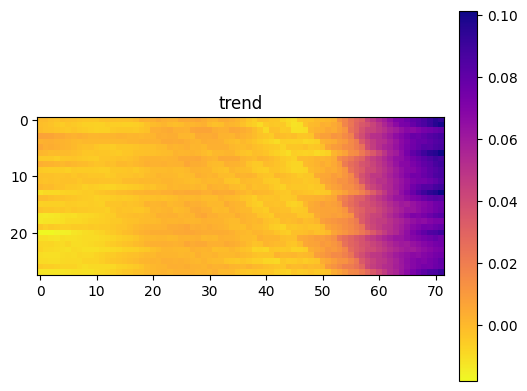

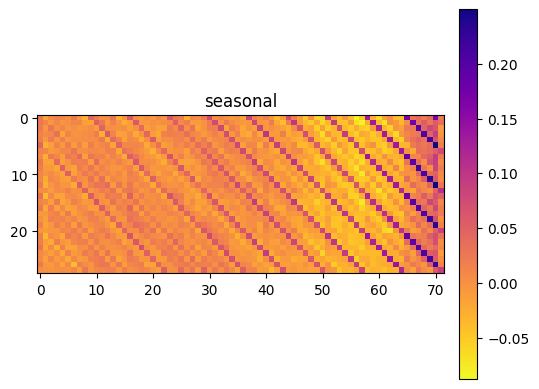

In [ ]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():    
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()